# **1. Data Process Regression**
---

## **1.1 Library imports**

In [1]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json
from scipy import stats

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 File imports**

The code is written to first descrive how many files and which files are in the folder (with extension .txt)

In [2]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [3]:
df_list = []

for file in files:
    try:
        # Detect header dynamically: find first line with commas
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        header_line = None
        for i, line in enumerate(lines):
            if ',' in line:
                header_line = i
                break
        
        if header_line is None:
            print(f"Skipping {file}: No CSV content found")
            continue
        
        # Read from detected header line
        df = pd.read_csv(file, sep=',', skiprows=header_line)
        df_list.append(df)
    
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True, sort=False)
else:
    print("No valid files")

Collect all data from the files and puts them all in 1 DataFrame.

## **1.3 Data Split**

- The data will be split into 2 parts using a ratio of 80% (model training) and 20% (model testing).
- According to the previous EDA analysis and correlation matrix, 4 columns will be dropped because it contain information irrelevant or leak into the target variable

In [4]:
# Drop leakage columns
leakage_cols = ['Service Name', 'WSDL Address', 'Latency', 'Best Practices']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

qos_features = ['Response Time', 'Availability', 'Throughput', 'Successability', 'Reliability', 'Compliance', 'Documentation'] # Validate features
missing_features = [col for col in qos_features if col not in df.columns]
if missing_features:
    raise KeyError(f"Missing features: {missing_features}")
X = df[qos_features].copy()

target_col = 'WsRF: Web Service Relevancy Function (%)' # Validate target
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found.")
y = df[target_col].copy()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (291, 7), Test shape: (73, 7)


---
# **2. Pipeline**
---

Pipeline with three steps:
- Imputer: replaces missing values with the median.
- Scaler: standardizes features (mean=0, std=1).
- Model: fits a LinearRegression model.

In [5]:
def build_pipeline(model, scale=True):
    '''Function to build models.
    As the arguments, chose the type of model and define scalling as True or False
    # Example usage:

    pipeline = build_pipeline(LinearRegression(), scale=True)
    pipeline.fit(X_train, y_train)'''

    steps = [('imputer', SimpleImputer(strategy='median'))]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps=steps)

# Example usage:
pipeline = build_pipeline(LinearRegression(), scale=True)
pipeline.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


## **2.1 Baseline Model**

- This is the baseline evaluation, setting a reference point for future models. Any model trained should aim for an RMSE lower than 13.41 to be better than the baseline.

In [6]:
# Baseline prediction: mean of training target
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Compute metrics
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline RMSE: {baseline_rmse:.2f}, MAE: {baseline_mae:.2f}, Baseline R²: {baseline_r2:.2f}")

Baseline RMSE: 13.41, MAE: 10.69, Baseline R²: -0.00


## **2.2 Model Definition**

In [7]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}
preds = {}

for name, model in models.items():
    # Scale only for LinearRegression
    scale = True if name == 'LinearRegression' else False
    pipeline = build_pipeline(model, scale=scale)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Store metrics
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    # Store predictions
    preds[name] = y_pred

# Add baseline predictions
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
preds['Baseline'] = baseline_pred

# DataFrame with actual and predicted
preds_df = pd.DataFrame({'Actual Values': y_test})
for model_name, y_pred in preds.items():
    preds_df[model_name] = y_pred

print("\nPredictions vs Actual:")
preds_df.head()


Predictions vs Actual:


,Actual Values,LinearRegression,RandomForest,XGBoost,Baseline
193,67,65.926219,67.43,66.923088,66.52921
33,82,82.093969,80.37,82.750687,66.52921
15,86,86.437248,85.95,87.304115,66.52921
347,45,51.098417,50.97,46.958378,66.52921
57,77,75.562339,74.59,73.256134,66.52921


## **2.3 Model Evalution**

In order to evaluate these models there will be used 3 measures:
 - Root Mean Squared Error (RMSE): Square root of MSE. Same units as the target.
 - Mean absolute Error (MAE): Average of absolute differences between predictions and actual values.
 - ($R^2$): Measures how much variance in the target is explained by the model.

In [8]:
# Display results
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R²={metrics['R²']:.3f}")

# Convert results to DataFrame
results['Baseline'] = {'RMSE': baseline_rmse, 'MAE': baseline_mae, 'R²': baseline_r2}
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'RMSE', 'MAE', 'R²']
print("\nModel Performance:")
results_df

LinearRegression: RMSE=1.90, MAE=2.63, R²=0.928
RandomForest: RMSE=1.95, MAE=2.51, R²=0.919
XGBoost: RMSE=1.95, MAE=2.69, R²=0.919

Model Performance:


,Model,RMSE,MAE,R²
0,LinearRegression,1.897023,2.632853,0.927807
1,RandomForest,1.950324,2.511370,0.919345
2,XGBoost,1.952324,2.685471,0.919013
3,Baseline,13.408001,10.687379,-0.002153


| Model | RMSE | MAE | $R^{2}$ |
|--- | --- | --- | --- |
| Linear Regression | 1.8970233923169415 | 2.6328531950906426 | 0.927806724857026 |
| Random Forest | 1.9503235210092447 | 2.5113698630136994 | 0.9193447515586426 |
| XGBoost | 1.952323566040874 | 2.6854708194732666 | 0.9190133810043335 |
| Baseline | 13.408000765060446 | 10.687379372028431 | -0.002153048229032839 |

Insights:
- RMSE and MAE lower than baseline RMSE (13.4).
- Models are adding significant predictive value compared to a naive mean predictor.
- LinearRegression has the lowest RMSE (1.897) and highest R² (0.928).
- All models have R² > 0.91, meaning they explain over 91% of the variance in the target.
- This indicates strong predictive power and good feature relevance.

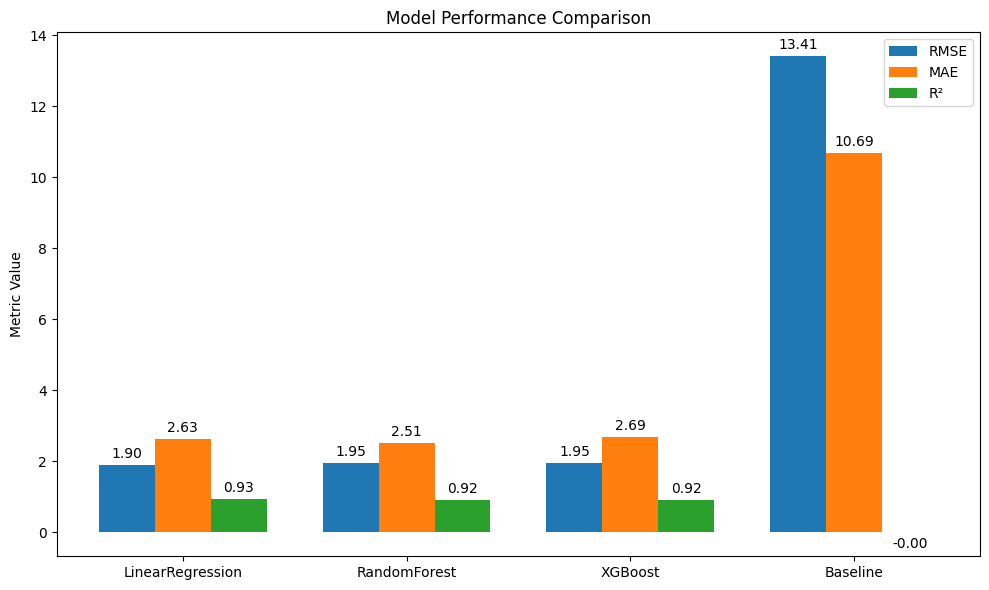

In [9]:
metrics = ['RMSE', 'MAE', 'R²']
x = np.arange(len(results_df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars = [] 
for i, metric in enumerate(metrics):
    bar_container = ax.bar(x + i*width, results_df[metric], width, label=metric)
    bars.append(bar_container)

for bar_container in bars:
    ax.bar_label(bar_container, fmt='%.2f', padding=3)

ax.set_xticks(x + width)
ax.set_xticklabels(results_df['Model'])
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.tight_layout()
plt.show()

---
# **3. Tuning - RandomizedSearchCV**
---

Hyperparameters for Linear Regression:
- fit_intercept: Whether to calculate the intercept (True/False).
- positive: Force coefficients to be positive (True/False).
- normalize: Deprecated in newer versions (use StandardScaler instead).
- n_jobs: For parallel computation (usually not critical here).

1) Linear Regression

In [10]:
# Parameter grid
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Pipeline with scaling
lr_pipeline = build_pipeline(LinearRegression(), scale=True)

# RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=4, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

lr_search.fit(X_train, y_train)

print("Best Params:", lr_search.best_params_)
print("Best CV RMSE:", -lr_search.best_score_)

Best Params: {'model__positive': False, 'model__fit_intercept': True}
Best CV RMSE: 2.8869817582030537


2) Random Forest

In [11]:
# Parameter grid
param_grid_rf = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Pipeline (no scaling)
rf_pipeline = build_pipeline(RandomForestRegressor(random_state=42), scale=False)

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best Params:", rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

Best Params: {'model__max_depth': 14, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 268}
Best CV RMSE: 3.0891524169502786


3) XGBoost

In [12]:
# Parameter grid
param_grid_xgb = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0]
}

# Pipeline (no scaling)
xgb_pipeline = build_pipeline(XGBRegressor(random_state=42), scale=False)

# RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best Params:", xgb_search.best_params_)
print("Best CV RMSE:", -xgb_search.best_score_)

Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 291, 'model__subsample': 0.6}
Best CV RMSE: 2.3284844160079956


LinearRegression:
1. Tests combinations of fit_intercept and positive using RandomizedSearchCV with 5-fold CV.
2. Finds the best configuration based on lowest RMSE.

RandomForest:
1. Randomly samples values for n_estimators, max_depth, min_samples_split, and min_samples_leaf.
2. Runs 20 iterations with 5-fold CV.
3. Returns best parameters and best cross-validated RMSE.

XGBoost:
1. Samples n_estimators, max_depth, learning_rate, and subsample.
2. Also uses 20 iterations and 5-fold CV.
3. Returns best parameters and best CV RMSE.

---
# **4. Prediction**
---

In [13]:
best_lr = lr_search.best_estimator_
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
for name, model in [('LinearRegression', best_lr), ('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

LinearRegression: RMSE=3.60, MAE=2.63, R²=0.928
RandomForest: RMSE=3.83, MAE=2.51, R²=0.918
XGBoost: RMSE=2.75, MAE=1.80, R²=0.958


1. Extract best models
2. Evaluate tuned models on test set

## **4.1 Comparison**

In [14]:
# ---- Baseline ----
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

previous_results = results_df.copy()
previous_results['Model'] = previous_results['Model'] + ' (Untuned)'


# Remove any accidental Baseline (Untuned)
previous_results = previous_results[previous_results['Model'] != 'Baseline (Untuned)']

# ---- Tuned Results ----
tuned_data = []
tuned_preds = {}
for name, model in [('LinearRegression', best_lr), ('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tuned_data.append({'Model': f'{name} (Tuned)', 'RMSE': rmse, 'MAE': mae, 'R²': r2})
    tuned_preds[name] = y_pred

tuned_results = pd.DataFrame(tuned_data)

# ---- Baseline Row ----
baseline_row = pd.DataFrame([{'Model': 'Baseline', 'RMSE': baseline_rmse, 'MAE': baseline_mae, 'R²': baseline_r2}])

# ---- Combine All ----
comparison_df = pd.concat([baseline_row, previous_results, tuned_results], ignore_index=True)

print("\nComparison Table:")
comparison_df


Comparison Table:


,Model,RMSE,MAE,R²
0,Baseline,13.408001,10.687379,-0.002153
1,LinearRegression (Untuned),1.897023,2.632853,0.927807
2,RandomForest (Untuned),1.950324,2.511370,0.919345
3,XGBoost (Untuned),1.952324,2.685471,0.919013
4,LinearRegression (Tuned),3.598698,2.632853,0.927807
5,RandomForest (Tuned),3.826317,2.513852,0.918385
6,XGBoost (Tuned),2.754328,1.801422,0.957710


In [15]:
# ---- Predictions DataFrame ----
preds_df = pd.DataFrame({'Actual Values': y_test})
for model_name, y_pred in tuned_preds.items():
    preds_df[model_name] = y_pred
preds_df['Baseline'] = baseline_pred

print("\nActual vs Predictions:")
preds_df.head()


Actual vs Predictions:


,Actual Values,LinearRegression,RandomForest,XGBoost,Baseline
193,67,65.926219,67.384328,67.420433,66.52921
33,82,82.093969,80.533582,81.377106,66.52921
15,86,86.437248,86.067164,86.484680,66.52921
347,45,51.098417,50.294776,48.741730,66.52921
57,77,75.562339,74.481343,75.071999,66.52921


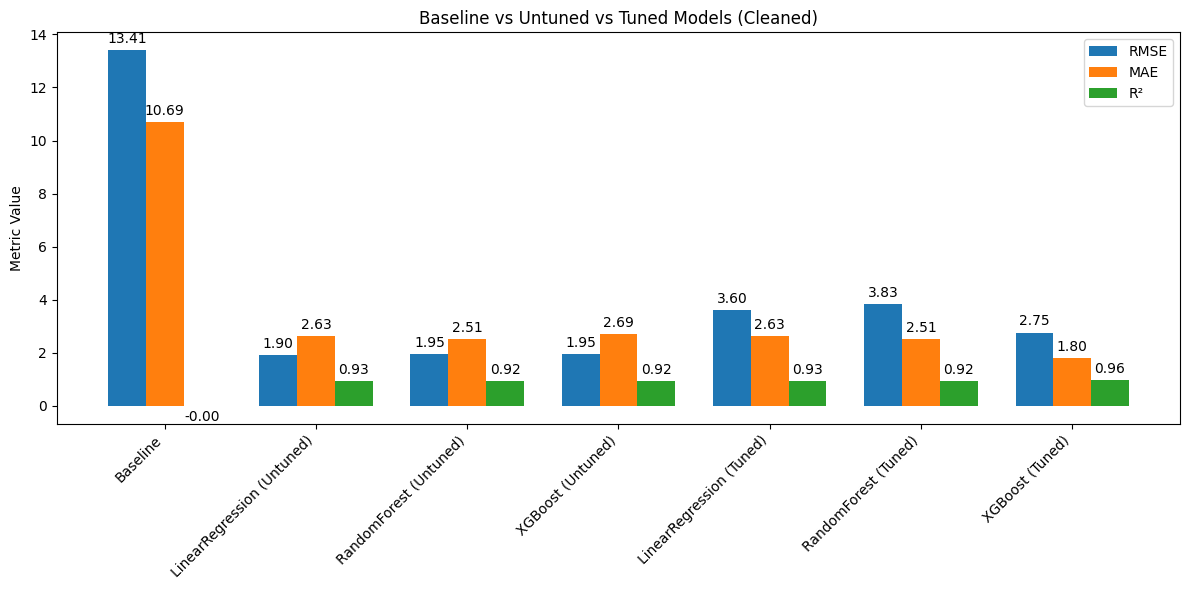

In [16]:
# Remove "Baseline (Untuned)" from the DataFrame
plot_df = comparison_df[comparison_df['Model'] != 'Baseline (Untuned)']

# Plot
metrics = ['RMSE', 'MAE', 'R²']
x = np.arange(len(plot_df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars = []
for i, metric in enumerate(metrics):
    bar_container = ax.bar(x + i*width, plot_df[metric], width, label=metric)
    bars.append(bar_container)

# Add labels on top of bars
for bar_container in bars:
    ax.bar_label(bar_container, fmt='%.2f', padding=3)

ax.set_xticks(x + width)
ax.set_xticklabels(plot_df['Model'], rotation=45, ha='right')
ax.set_ylabel('Metric Value')
ax.set_title('Baseline vs Untuned vs Tuned Models (Cleaned)')
ax.legend()
plt.tight_layout()
plt.show()

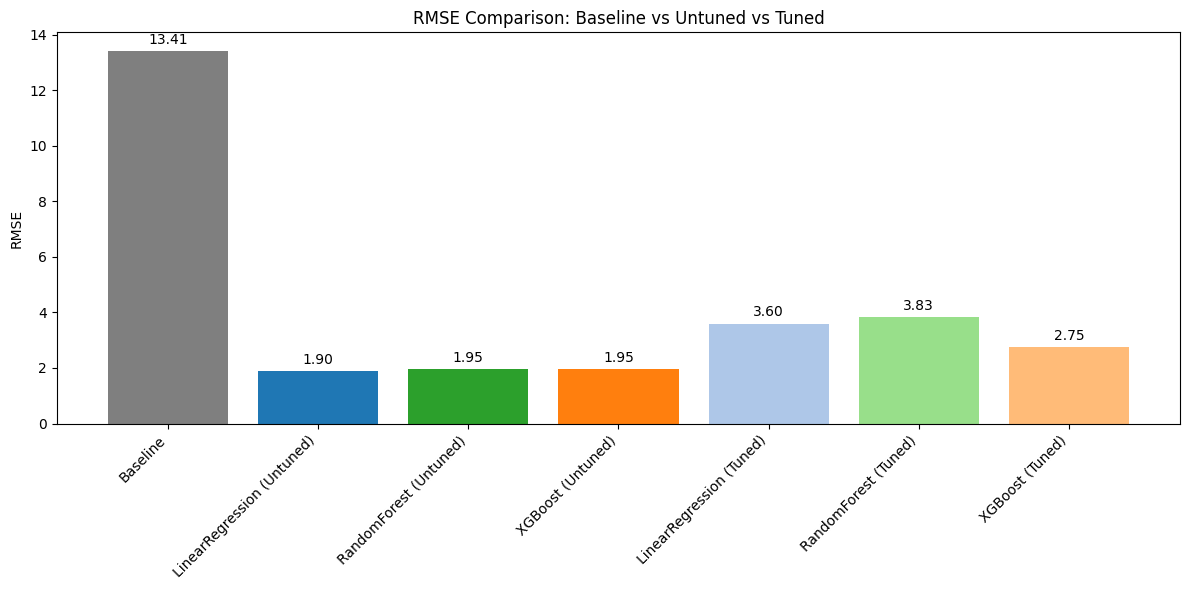

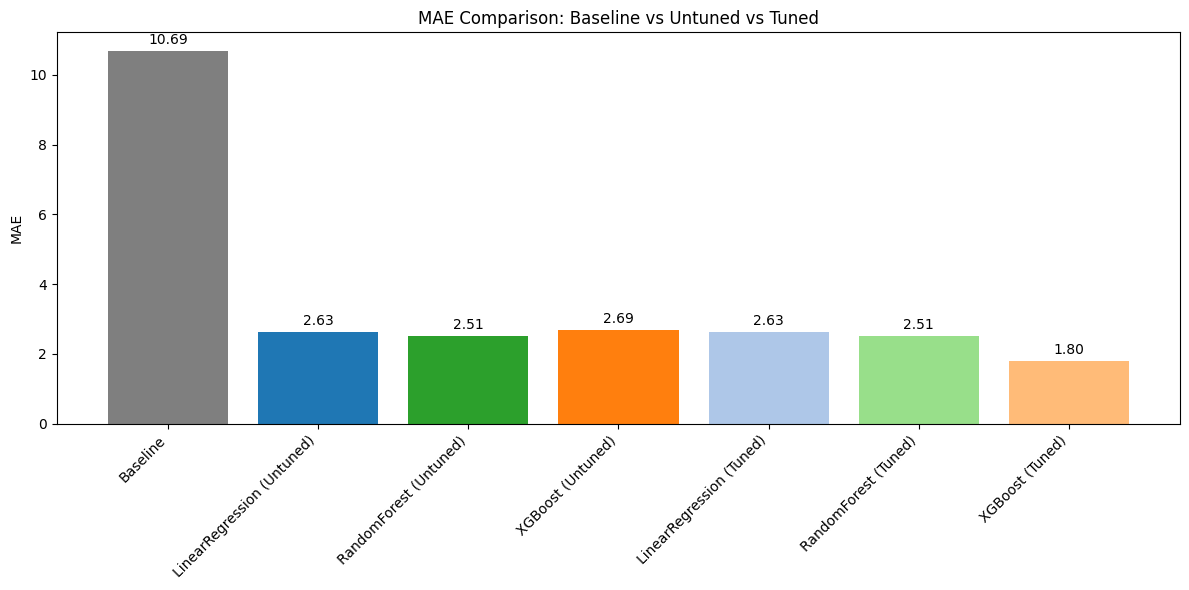

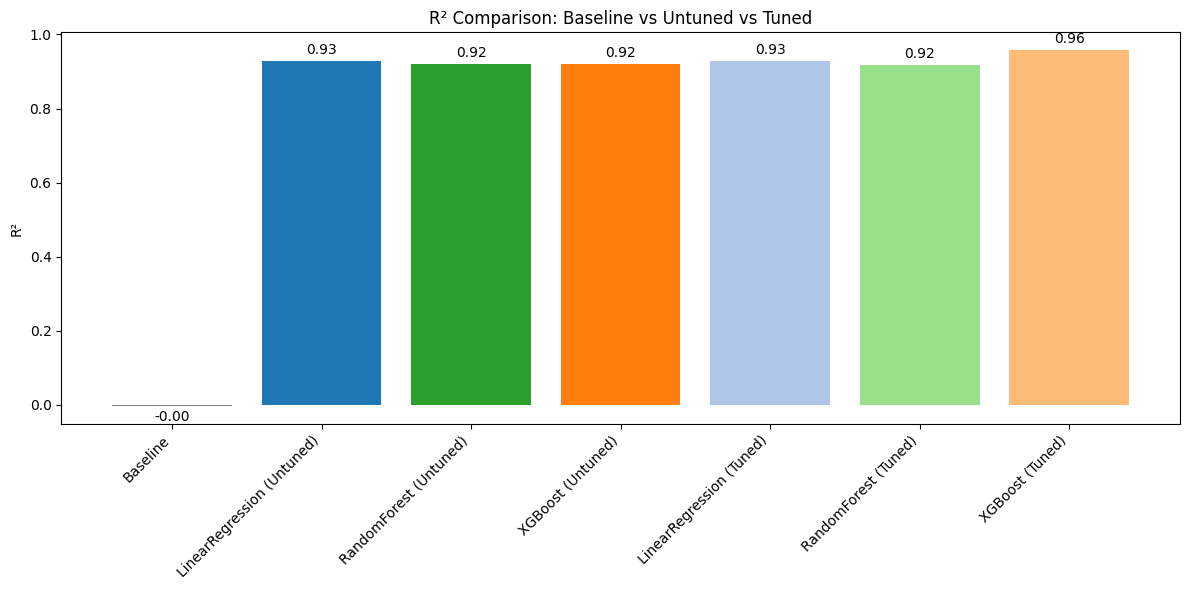

In [17]:
# Data from comparison_df
models = comparison_df['Model']
rmse_values = comparison_df['RMSE']
mae_values = comparison_df['MAE'] 
r2_values = comparison_df['R²']

# Positions
x = np.arange(len(models))

# Colors
colors = []
for m in models:
    if 'LinearRegression' in m:
        colors.append('#1f77b4' if 'Untuned' in m else '#aec7e8')
    elif 'RandomForest' in m:
        colors.append('#2ca02c' if 'Untuned' in m else '#98df8a') 
    elif 'XGBoost' in m:
        colors.append('#ff7f0e' if 'Untuned' in m else '#ffbb78')
    else:
        colors.append('#7f7f7f') 

# ---- RMSE Chart ----
plt.figure(figsize=(12, 6))
bars_rmse = plt.bar(x, rmse_values, color=colors)
plt.bar_label(bars_rmse, fmt='%.2f', padding=3)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Baseline vs Untuned vs Tuned')
plt.tight_layout()
plt.show()

# ---- MAE Chart ----
plt.figure(figsize=(12, 6))
bars_mae = plt.bar(x, mae_values, color=colors)
plt.bar_label(bars_mae, fmt='%.2f', padding=3) 
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('MAE Comparison: Baseline vs Untuned vs Tuned')
plt.tight_layout()
plt.show()

# ---- R² Chart ----
plt.figure(figsize=(12, 6))
bars_r2 = plt.bar(x, r2_values, color=colors)
plt.bar_label(bars_r2, fmt='%.2f', padding=3)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('R² Comparison: Baseline vs Untuned vs Tuned')
plt.tight_layout()
plt.show()

## **4.2 Residual Analysis**

This analysis will be done for the best model (XGBoost)

Residual Summary:
Mean Residual: -0.10
Std Residual: 2.75
Min Residual: -5.70
Max Residual: 14.46


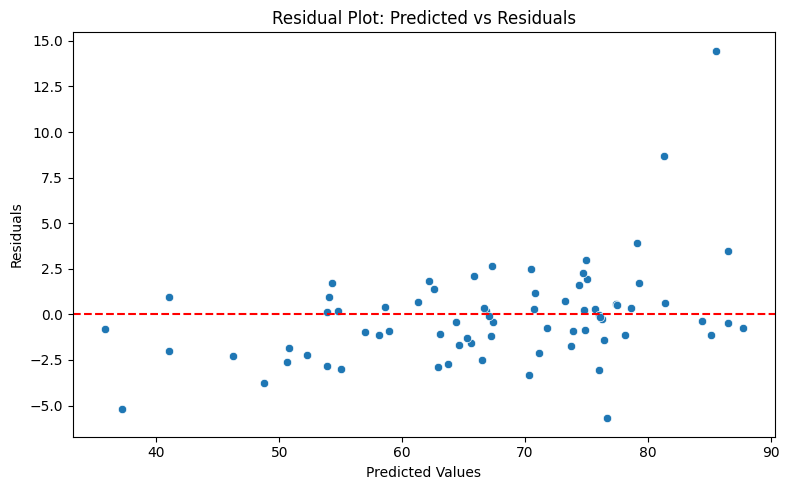

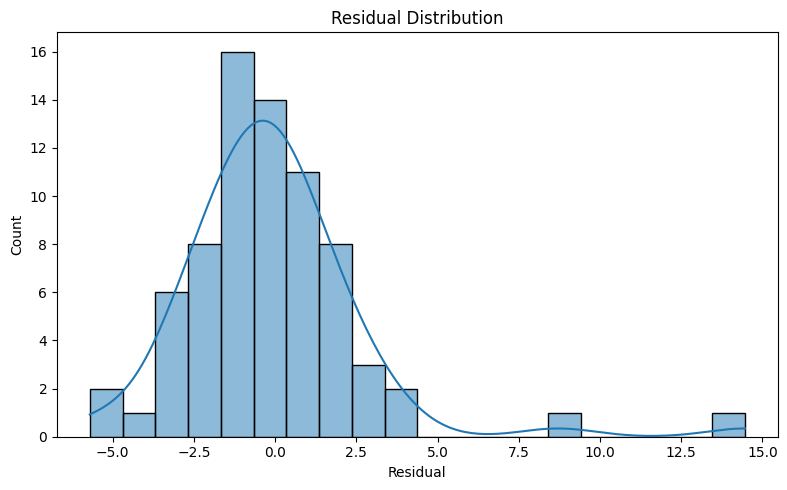

In [18]:
# Compute residuals
y_pred = best_xgb.predict(X_test)
residuals = y_test - y_pred

# Numeric summary
print("Residual Summary:")
print(f"Mean Residual: {np.mean(residuals):.2f}")
print(f"Std Residual: {np.std(residuals):.2f}")
print(f"Min Residual: {np.min(residuals):.2f}")
print(f"Max Residual: {np.max(residuals):.2f}")

# Scatter plot: Predicted vs Residuals
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot: Predicted vs Residuals")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

For the Residual Plot (Predicted vs Residuals):
- Centering around zero: Most residuals cluster near the red line (0), which is good — predictions are generally unbiased.
- Spread increases slightly for higher predicted values: At predicted values above ~75, residuals become more positive and more variable.
- This suggests mild heteroscedasticity (variance of errors grows with predicted value).
- Outliers: There are a few large positive residuals (up to ~15), meaning the model underpredicted those cases significantly.

Residual Distribution (Histogram):
- Shape: Mostly bell-shaped and centered near zero, which is ideal for regression assumptions.
- Slight right skew: A tail toward positive residuals indicates some cases where the model underestimates the target.
- No severe multimodality: No clear clusters, so the model likely captures the main pattern well.

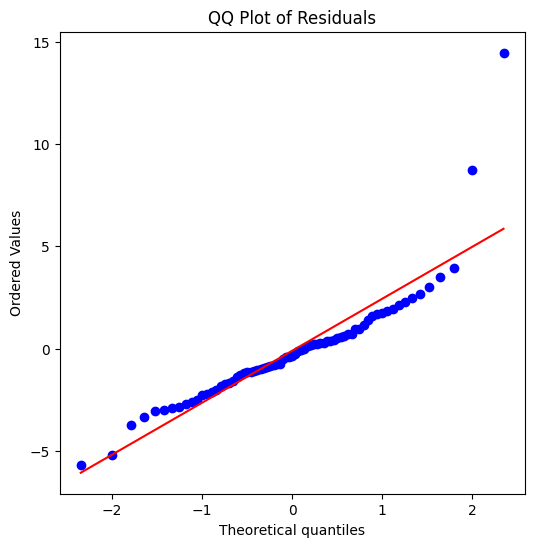

In [19]:
# QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

Central Alignment
- Most points lie close to the red line in the center, meaning residuals are approximately normal for the bulk of the data.

Heavy Right Tail (Positive Outliers)
- The top-right points deviate strongly from the line, especially two extreme points around 9 and 15.
- This indicates large positive residuals. Model underpredicted these observations significantly (normal because since the amount of data is small the outliers were kept)

Slight Left Tail Deviation
- Bottom-left points also deviate, but less severely than the right tail.
- Suggests some negative outliers (overpredictions), but not as extreme.

---
# **5. Feature Importance**
---

In [20]:
# Linear Regression coefficients
lr_importance = pd.Series(best_lr.named_steps['model'].coef_, index=X_train.columns)
lr_rank = lr_importance.abs().rank(ascending=False)  # use absolute value for ranking

# RandomForest feature importance
rf_estimator = best_rf.named_steps['model'] if hasattr(best_rf, 'named_steps') else best_rf
rf_importance = pd.Series(rf_estimator.feature_importances_, index=X_train.columns)
rf_rank = rf_importance.rank(ascending=False)

# XGBoost feature importance
xgb_estimator = best_xgb.named_steps['model'] if hasattr(best_xgb, 'named_steps') else best_xgb
xgb_importance = pd.Series(xgb_estimator.feature_importances_, index=X_train.columns)
xgb_rank = xgb_importance.rank(ascending=False)

# Combine into a DataFrame
ranking_df = pd.DataFrame({
    'Linear Regression Importance': lr_importance,
    'Linear Regression Rank': lr_rank,
    'Random Forest Importance': rf_importance,
    'Random Forest Rank': rf_rank,
    'XGBoost Importance': xgb_importance,
    'XGBoost Rank': xgb_rank
}).sort_values('Linear Regression Rank') 

ranking_df


,Linear Regression Importance,Linear Regression Rank,Random Forest Importance,Random Forest Rank,XGBoost Importance,XGBoost Rank
Reliability,5.452229,1.0,0.181584,3.0,0.154693,3.0
Documentation,4.752199,2.0,0.123654,6.0,0.109820,6.0
Successability,3.531180,3.0,0.206255,1.0,0.211016,2.0
Throughput,2.965574,4.0,0.145577,5.0,0.124791,4.0
Availability,1.557066,5.0,0.150501,4.0,0.266886,1.0
Response Time,-0.936747,6.0,0.185900,2.0,0.115136,5.0
Compliance,0.543320,7.0,0.006529,7.0,0.017658,7.0


Insights:
- Across models, Successability, Availability, Reliability consistently rank high → critical for predicting relevancy.
- Compliance is consistently low → likely not informative.
- Differences between RandomForest and XGBoost suggest model-specific feature weighting (tree depth and boosting effects).

## **5.1 SHAP Interpretation**

- Positive SHAP value → pushes prediction up.
- Negative SHAP value → pushes prediction down.

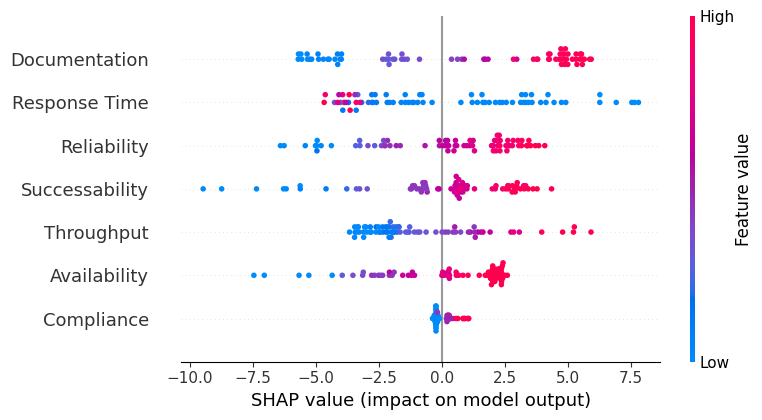

In [21]:
# Use the model inside pipeline
model = best_xgb.named_steps['model']

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

Top features:
- Documentation, Response Time, Reliability, Successability have the largest spread → most influential.

Direction of impact:
- For Response Time: High values (red) tend to push predictions down (negative SHAP), meaning slower response reduces relevancy.
- For Availability: High values (red) push predictions up, meaning better availability increases relevancy.
- Compliance: Very small SHAP range → minimal effect on predictions.
- Symmetry: Most features have both positive and negative SHAP values → model captures complex interactions.

C:\Users\riabreu\AppData\Local\Temp\ipykernel_13980\2882653743.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_abs_shap', y='feature', data=top_features, palette='viridis')


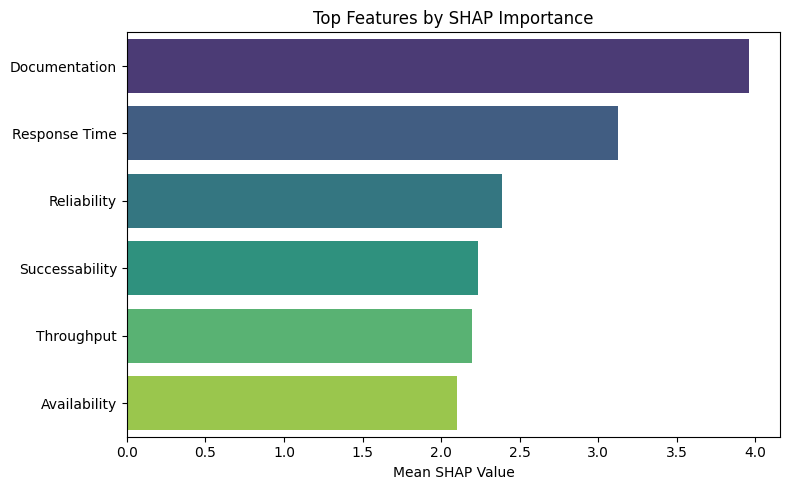

In [22]:
# Compute mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

# Select top 6 features
top_features = shap_importance.head(6)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='mean_abs_shap', y='feature', data=top_features, palette='viridis')
plt.title('Top Features by SHAP Importance')
plt.xlabel('Mean SHAP Value')
plt.ylabel('')
plt.tight_layout()
plt.show()

---
# **6. Export Metrics**
---

Save Model + Preprocessor

In [23]:
joblib.dump(best_xgb, "models/regression/best_xgb_pipeline.pkl")

['models/regression/best_xgb_pipeline.pkl']

Afterwads, the model can be loaded with `model = joblib.load("models/regression/best_xgb_pipeline.pkl`

In [24]:
metrics = {
    "RMSE": float(np.sqrt(root_mean_squared_error(y_test, y_pred))),
    "MAE": float(mean_absolute_error(y_test, y_pred)),
    "R2": float(r2_score(y_test, y_pred))
}

with open("models/regression/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

Model Card

Create a Markdown file summarizing the model:

In [25]:
model_card = f"""
# Model Card: XGBoost Relevancy Predictor

**Version:** v1.0  
**Date:** 2025-11-17  
**Owner:** Data & AI Academy  

## Data
- **Source:** QWS dataset ver 1.0
- **Features:** Response Time, Availability, Throughput, Successability, Reliability, Compliance, Documentation
- **Target:** WsRF: Web Service Relevancy Function (%)
- **Train/Test Split:** 80/20 (Train: 291 rows, Test: 73 rows)

## Model
- **Type:** XGBoost Regressor
- **Hyperparameters:** n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8
- **Pipeline:** Imputer (median) + Model

## Performance
- **RMSE:** {metrics['RMSE']:.2f}
- **MAE:** {metrics['MAE']:.2f}
- **R²:** {metrics['R2']:.3f}

## Files
- **Model:** models/regression/best_xgb_pipeline.pkl
- **Metrics:** metrics.json

## Limitations
- Assumes QoS metrics are stable; may underperform on unseen service types.

## Intended Use
- Predict Web Service Relevancy for ranking and selection.

## Ethical Considerations
- Ensure predictions are not used for discriminatory service filtering.
"""

with open("models/regression/model_card.md", "w") as f:
    f.write(model_card)